# validate $q^C_\phi(Y\,|\,X)$ and $q^T_\phi(Y\,|\,X)$ using test data

In [1]:
import os, glob
import numpy as np
import astropy.table as aTable
from tqdm.notebook import tqdm, trange

In [2]:
import torch

In [3]:
from tarp import get_drp_coverage

In [4]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

## read compiled dataset

In [5]:
data = aTable.Table.read('/scratch/gpfs/chhahn/noah/zipcode.fema.fsf.acs.rainfall.v2.csv', format='csv')
print('%i entries; %i unique zipcodes' % (len(data), len(np.unique(data['reportedZipcode']))))

74288 entries; 14729 unique zipcodes


In [6]:
control = (data['communityRatingSystemDiscount'] == 11.)
print(f"{np.sum(control)} entries in control; {len(np.unique(data['reportedZipcode'][control]))} unique zipcodes")

treat = (data['communityRatingSystemDiscount'] < 11.)
print(f"{np.sum(treat)} entries in control; {len(np.unique(data['reportedZipcode'][treat]))} unique zipcodes")

43644 entries in control; 11258 unique zipcodes
30644 entries in control; 5040 unique zipcodes


In [7]:
columns = ['amountPaidOnTotalClaim_per_policy', 'mean_rainfall', 'avg_risk_score_all', 
           'median_household_income', 'population', 'renter_fraction', 'educated_fraction', 'white_fraction'] 

In [8]:
control_data = np.vstack([np.ma.getdata(data[col][control].data) for col in columns]).T
control_data[:,0] = np.log10(control_data[:,0])
control_data[:,3] = np.log10(control_data[:,3])
control_data[:,4] = np.log10(control_data[:,4])

treat_data = np.vstack([np.ma.getdata(data[col][treat].data) for col in columns]).T
treat_data[:,0] = np.log10(treat_data[:,0])
treat_data[:,3] = np.log10(treat_data[:,3])
treat_data[:,4] = np.log10(treat_data[:,4])

## read $q^C_\phi(Y\,|\,X)$ and $q^T_\phi(Y\,|\,X)$

In [10]:
def read_qphi(nde_name):
    qphis = []
    for fqphi in glob.glob('../dat/nde/%s/*.pt' % nde_name): 
        qphi = torch.load(fqphi, map_location=device)
        qphis.append(qphi)
    return qphis

In [11]:
qphis_control = read_qphi('qphi_control')
qphis_treat = read_qphi('qphi_treat')

2313 models trained
[680, 1365, 1087, 78, 7]
2609 models trained
[462, 1287, 1547, 2243, 269]


## validate $q^C_\phi(Y\,|\,X)$ and $q^T_\phi(Y\,|\,X)$ using DRP coverage test
See [Lemos et al (2023)](https://ui.adsabs.harvard.edu/abs/2023PMLR..20219256L/abstract) for details on the DRP coverage test.

In [37]:
i_test_control = np.random.choice(np.arange(control_data.shape[0]), size=int(control_data.shape[0] * 0.1))
i_test_treat = np.random.choice(np.arange(treat_data.shape[0]), size=int(treat_data.shape[0] * 0.1))

In [38]:
n_sample = 10000

y_nde_control = []
for i in tqdm(i_test_control): 
    y_samp = []
    for qphi_control in qphis_control: 
        _samp = qphi_control.sample((int(n_sample/len(qphis_treat)),), 
                                    x=torch.tensor(control_data[i,1:], dtype=torch.float32).to(device), 
                                    show_progress_bars=False)
        y_samp.append(_samp.detach().cpu().numpy())

    y_nde_control.append(np.concatenate(np.array(y_samp), axis=0))        
y_nde_control = np.array(y_nde_control)


y_nde_treat = []
for i in tqdm(i_test_treat): 
    y_samp = []
    for qphi_treat in qphis_treat: 
        _samp = qphi_treat.sample((int(n_sample/len(qphis_treat)),), 
                                    x=torch.tensor(treat_data[i,1:], dtype=torch.float32).to(device), 
                                    show_progress_bars=False)
        y_samp.append(_samp.detach().cpu().numpy())

    y_nde_treat.append(np.concatenate(np.array(y_samp), axis=0))        
y_nde_treat = np.array(y_nde_treat)

  0%|          | 0/4364 [00:00<?, ?it/s]

  0%|          | 0/3064 [00:00<?, ?it/s]

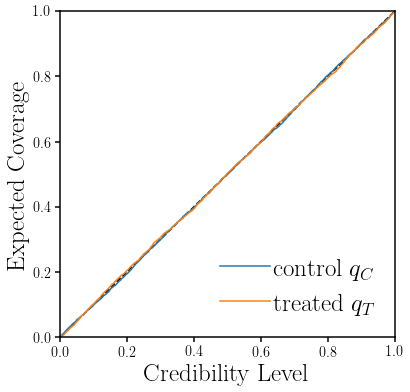

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], ls="--", color="k")
alpha, ecp = get_drp_coverage(np.swapaxes(y_nde_control, 0, 1), control_data[i_test_control,0][:,None], 
                              references="random", metric="euclidean")
ax.plot(alpha, ecp, color='C0', label='control $q_C$') 

alpha, ecp = get_drp_coverage(np.swapaxes(y_nde_treat, 0, 1), treat_data[i_test_treat,0][:,None], 
                              references="random", metric="euclidean")
ax.plot(alpha, ecp, color='C1', label='treated $q_T$')

ax.legend(loc='lower right', handletextpad=0.1, fontsize=25)
ax.set_ylabel("Expected Coverage", fontsize=25)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=25)
ax.set_xlim(0., 1.)
fig.savefig('../figs/coverage_test.pdf', bbox_inches='tight')